# How does GPT-2 process figurative language? Comparing surprisal to N400 effects in response to novel metaphors

**Reeka Estacio**

Professor Sean Trott

COGS 150

Final Project

### Install and load libraries & packages

In [ ]:
# %pip install transformers

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
import torch
import transformers
from transformers import AutoTokenizer

## Introduction

One prominent application of LLMs is to understand and model human language processing. Research in this area gives a lot of insight into how language statistics influence how we process language. Processing figurative language, on the other hand, is particularly interesting because arriving at the true intended meaning requires that we are able to parse between literal and figurative interpretations. Whereas humans seem to do this implicitly, the question stands on whether LLMs share this ability, emergent solely from language statistics.

[Tartter et al. (2002)](https://doi.org/10.1006/brln.2001.2610) addresses figurative language processing in humans, specifically in response to novel metaphors. The ERP recordings that were captured in this study show a robust N400 effect to anomalous sentence endings, but not for metaphorical or literal sentence endings. The absence of a significant N400 effect for metaphorical endings was attributed to differences in earlier processing windows (N200) involved in syntactic constraint and selection restrictions.

In this analysis, I aim to explore whether GPT-2 responds similarly to novel metaphors as they do in the [Tartter et al. (2002)](https://doi.org/10.1006/brln.2001.2610) human ERP study, operationalizing the N400 effect with surprisal. If GPT-2 behaves similarly to humans in this manner, then (1) literal sentence endings will elicit lower surprisal values, (2) anomalous sentence endings will elicit higher surprisal values, and (3) there is no significant difference in surprisal between literal and metaphorical sentence endings.

## Methods

### Stimuli

The stimuli used in this analysis is a subset of the stimuli used in the [Tartter et al. (2002)](https://www.sciencedirect.com/science/article/pii/S0093934X01926100) paper. There are selected 25 sentence frames (`context`). Each sentence frame has three variations that differ in the final word corresponding to the three conditions: (1) metaphor, (2) anomaly, (3) literal. Here is one example from the  set of stimuli, with the critical words in bold:

  - `metaphor`: *The children playing in the park trampled the soft green **carpet**.*
  - `anomaly` : *The children playing in the park trampled the soft green **bedspread**.*
  - `literal` : *The children playing in the park trampled the soft green **grass**.*

[Link to full set of stimuli](https://docs.google.com/spreadsheets/d/1vA7k2W0N2SyZVZNJ_KdTCV7zHDnWAtRvQZbXZFuge9Q/edit?usp=sharing)

In [ ]:
# load data
df_stims = pd.read_csv('COGS150_stims.csv')
df_stims.head(5)

,item,condition,context,final_word
0,0,metaphor,The orchestra filled the concert hall with,sunshine
1,0,anomaly,The orchestra filled the concert hall with,hail
2,0,literal,The orchestra filled the concert hall with,music
3,1,metaphor,The children playing in the park trampled the ...,carpet
4,1,anomaly,The children playing in the park trampled the ...,bedspread


#### Obtaining surprisal

For this analysis, I will be running the sentences through the pre-trained GPT-2 language model to obtain the surprisal for the critical word of each sentence. In this section, I have:
- loaded the model
- defined function `prob()` that extracts the probability of the critical word
- defined function `surprisal()` that calculates the surprisal of the critical word, using the probability obtained from the function above
- created a DataFrame called `df_results` that stores the `Context`, `Critical Word`, `Condition`, and `Surprisal` of every sentence in `df_stims`.

In [ ]:
# load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("gpt2")
gpt2 = transformers.AutoModelForCausalLM.from_pretrained("gpt2")
gpt2.eval()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [ ]:
# define function to obtain probability of critical word
def prob(model, tokenizer, context, critical_word):

  # tokenize context and critical word
  context_tokens = tokenizer.encode(context, return_tensors='pt')
  critical_tokens = tokenizer.encode(critical_word)

  # obtain log probability of critical word tokens
  log_probs = []
  for critical_token in critical_tokens:

    with torch.no_grad():
      logits = model(context_tokens).logits

    next_token_logits = logits[0,-1]
    next_token_probs = torch.softmax(next_token_logits, 0)

    prob = next_token_probs[critical_token]
    log_probs.append(torch.log(prob))

    context_tokens = torch.cat((context_tokens, torch.tensor([[critical_token]])), 1)

  # add log probabilities of critical word tokens
  total_log_prob = sum(log_probs)

  # return to probability
  total_prob = torch.exp(total_log_prob)

  return total_prob.item()


In [ ]:
# define function to calculate surprisal
def surprisal(p):
  return -np.log2(p)

The following code will iterate through the sentences in `df_stims` to obtain the surprisal of the critical word.

In [ ]:
results = []
for index, row in tqdm(df_stims.iterrows(), total=df_stims.shape[0]):

  probability = prob(gpt2, tokenizer, row['context'], row['final_word'])

  results.append({
      'Sentence' : row['context'],
      'Critical Word' : row['final_word'],
      'Condition' : row['condition'],
      'Surprisal' : surprisal(probability)
  })

df_results = pd.DataFrame(results)

100%|██████████| 75/75 [00:28<00:00,  2.66it/s]


## Results

In [ ]:
 df_results.head(5)

,Sentence,Critical Word,Condition,Surprisal
0,The orchestra filled the concert hall with,sunshine,metaphor,28.618004
1,The orchestra filled the concert hall with,hail,anomaly,31.445787
2,The orchestra filled the concert hall with,music,literal,22.083204
3,The children playing in the park trampled the ...,carpet,metaphor,20.334610
4,The children playing in the park trampled the ...,bedspread,anomaly,30.411844


In [ ]:
# average surprisal of each condition
df_results.groupby('Condition').mean()

<ipython-input-10-89a2242c63a1>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_results.groupby('Condition').mean()


,Surprisal
Condition,
anomaly,29.666827
literal,23.431236
metaphor,31.116679


<Axes: xlabel='Condition', ylabel='Surprisal'>

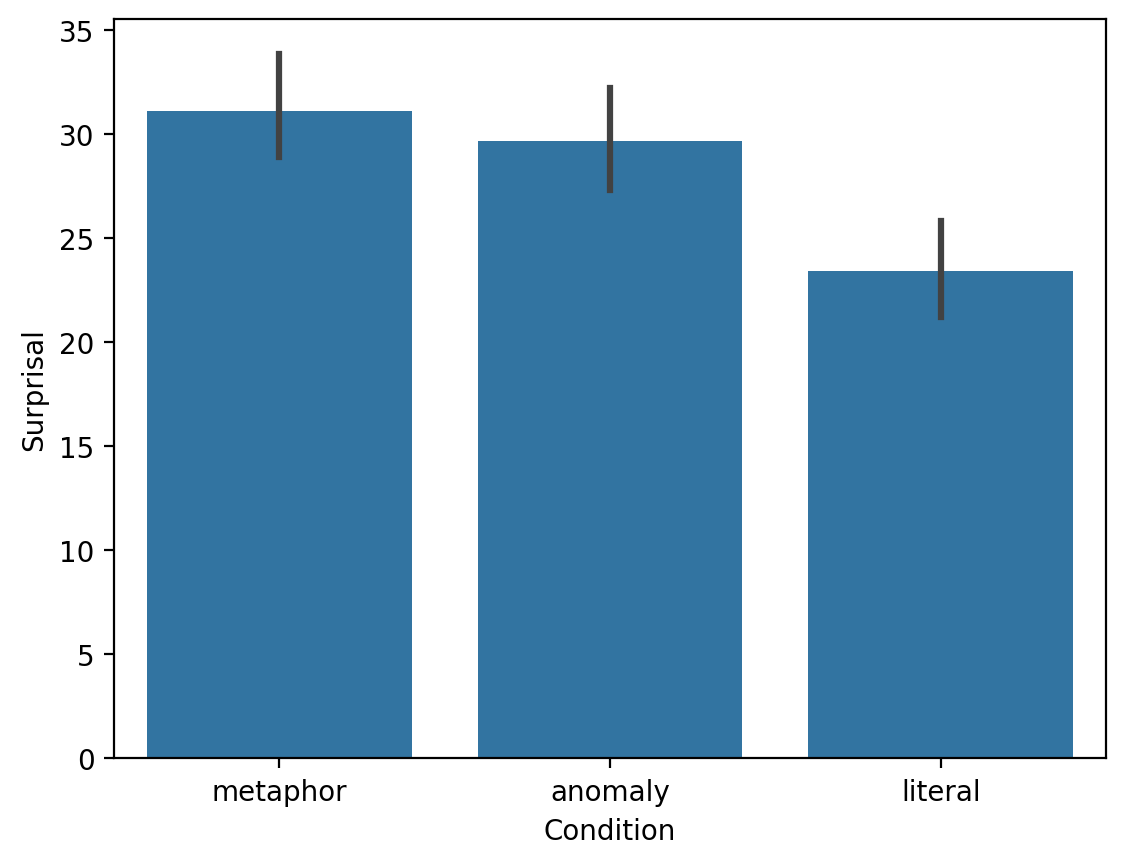

In [ ]:
# visualization of average surprisal of each condition
sns.barplot(data=df_results, x = 'Condition', y = 'Surprisal')

The results show that `literal` sentence endings result in the lowest average surprisal ($23.43$) among the other conditions. The `metaphor` condition exhibits the highest average surprisal ($31.12$).  However, it does not surpass the `anomaly` average surprisal ($29.67$) by a significant margin. Notably, the average surprisal for `metaphor` and `literal` sentence endings differ much more significantly than what was observed with the N400 effect in the original ERP study.

## Discussion

The current study aims to replicate the findings observed in the [Tartter et al. (2002)](https://doi.org/10.1006/brln.2001.2610) ERP study with the pre-trained language model GPT-2. Operating under the assumption that GPT-2 accurately models the N400 effect, it was predicted that (1) literal sentence endings elicit smaller surprisals, (2) anomalous sentence endings elicit the largest surprisals, and (1) there are no significant differences between surprisals for metaphorical and literal sentence endings.

The results obtained from the model indicate that average surprisal for literal sentence endings are indeed lower than the other conditions, consistent with the findings of the original paper. This is compatible with the intuition that expected sentence endings elicit attenuated N400 responses and lower surprisals—a pattern that is reinforced by a wide range of other related research. Indeed, GPT-2 assigns higher probabilities to literal sentence endings, which are more expected than anomalous or figurative endings.

Anomalous sentence endings do elicit relatively larger surprisal values than literal sentence endings, but not as large as metaphorical endings. This is inconsistent with the findings of the original study, which demonstrates that anomalous endings evoke greater N400 responses than the other conditions. Additionally, there is clear difference in average suprisal for literal and metaphorical sentence endings, again inconsistent with the original study. Metaphorical endings elicited the greatest surprisals, however not significantly larger than the anomalous endings.

Whereas Tartter et al. claim that humans do not initially treat metaphorical language as anomalous, these results seem to indicate that novel metaphors could be processed as anomalous by GPT-2. On a much larger scale, these differences could also suggest that human language processing is just fundamentally different from LLMs, such that we rely on other knowledge outside of language statistics—like embodied experience—to better parse between literal and figurative interpretations, ultimately arriving at the intended meaning much more efficiently than GPT-2.

### Limitations
There are a number of possible reasons why the current study obtained different results than the original 2002 ERP study. As mentioned, it could just be that human language processing is fundamentally different than how LLMs process language. Furthermore, the stimuli used in this analysis is only a subset of the stimuli used in the original paper, so it is possible that a larger sample could provide results that are more consistent with the results obtained in the original 2002 study.

There could also be issues in the way that the ERP responses were operationalized as surprisal. In this paper, it is assumed that surprisal accurately and exclusively models the N400 effect. However, it is possible that surprisal also encompasses the N200 component mentioned in the original study, to which they attributed the initial differences in literal and metaphorical sentence processing. In other words, greater N200 effects elicited from metaphorical sentences could be associated with greater surprisal, in tandem with the N400 effect.

## Conclusion

Overall, in this replication of the [Tartter et al. (2002)](https://doi.org/10.1006/brln.2001.2610) study, average surprisal values indicate that GPT-2 processes metaphorical language differently than humans. While low surprisals obtained from literal sentence endings are consistent with attenuated N400 effects and high surprisals obtained from anomalous sentence ending are consistent with more robust N400 effects in human ERP studies, no clear conclusions can be drawn about how GPT-2 processes metaphorical language. Ultimately, this analysis calls for further examination of how figurative language is processed, both in humans and in LLMs.

## References

Tartter, V. C., Gomes, H., Dubrovsky, B., Molholm, S., Stewart, R. V. (2002). Novel Metaphors Appear Anomalous at Least Momentarily: Evidence from N400.
*Brain and Language*, *80*(3), 488-509. https://doi.org/10.1006/brln.2001.2610.